In [53]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [54]:
dti_folder = "/biodata/nyanovsky/datasets/dti/"

In [55]:
import pickle
G = pickle.load(open(dti_folder+"dti_graph.pickle",'rb'))

In [60]:
def get_rel_subgraph(G: nx.Graph, rel: str) -> nx.Graph:
    rel_edges = [(u,v) for (u,v,r_dict) in G.edges.data() if r_dict["edge_type"]==rel]
    rel_subgraph = G.edge_subgraph(rel_edges).copy()
    return rel_subgraph

In [61]:
ChG_subgraph = get_rel_subgraph(G, "Chem-Gene")
ChCh_subgraph = get_rel_subgraph(G, "Chem-Chem")
GG_subgraph = get_rel_subgraph(G, "Gene-Gene")

In [62]:
from collections import Counter
plt.style.use("ggplot")

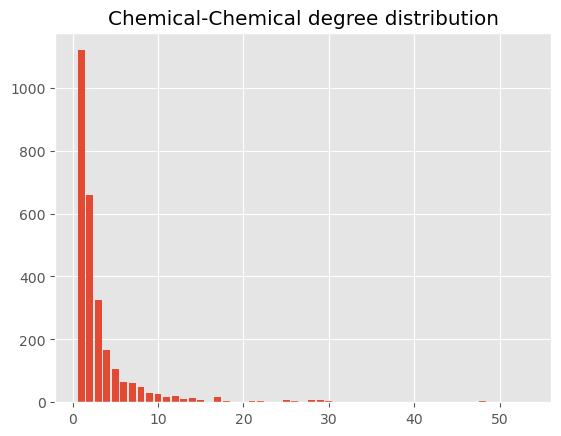

In [79]:
ChCh_degs = [deg for node, deg in ChCh_subgraph.degree()]
deg, counts = zip(*Counter(ChCh_degs).items())
plt.bar(deg,counts)
plt.title("Chemical-Chemical degree distribution")
plt.show()

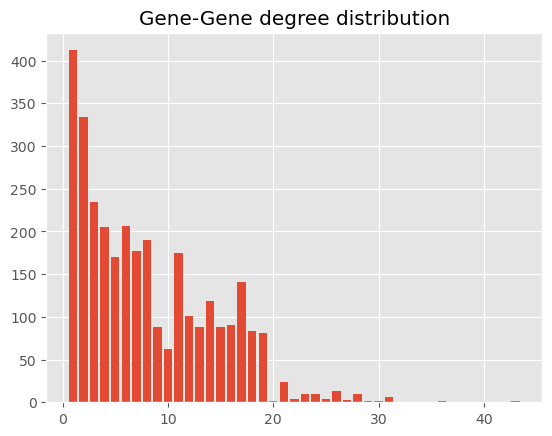

In [80]:
GG_degs = [deg for node, deg in GG_subgraph.degree()]
deg, counts = zip(*Counter(GG_degs).items())
plt.bar(deg,counts)
plt.title("Gene-Gene degree distribution")
plt.show()

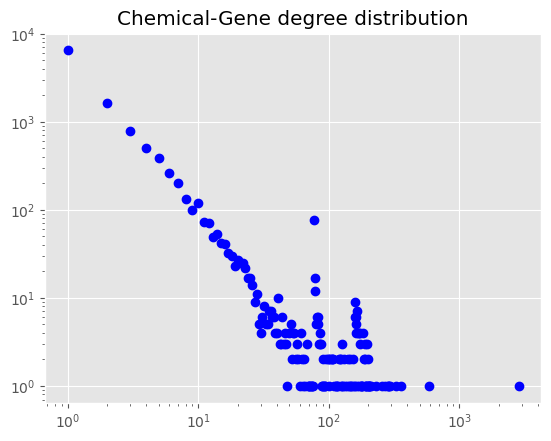

In [81]:
ChG_degs = [deg for node, deg in ChG_subgraph.degree()]
deg, counts = zip(*Counter(ChG_degs).items())
plt.loglog(deg,counts, "bo")
plt.title("Chemical-Gene degree distribution")
plt.show()

In [49]:
sorted(ChG_subgraph.degree(), key=lambda x:x[1])[-20:] 
# el de 2840 es Ca[2+], tiene sentido tener iones como compuestos?
# el top 3 de proteinas son citocromos p450, conviene mergearlos en un solo nodo?

[('C4095', 196),
 ('C2520', 198),
 ('C3715', 200),
 ('C3696', 200),
 ('C2170', 202),
 ('C4543', 203),
 ('C2160', 205),
 ('C2818', 206),
 ('C2801', 211),
 ('G1557', 230),
 ('C5329102', 257),
 ('G1544', 271),
 ('C544', 284),
 ('C23978', 286),
 ('G2099', 287),
 ('G1559', 296),
 ('G1565', 330),
 ('C14290', 356),
 ('G1576', 587),
 ('C271', 2840)]

Veamos transitividad en la red, i.e cuantos triangulos se cierran de la forma Ch-Ch-G o G-G-Ch (Quiero ver si compuestos similares se pegan a las mismas proteinas, o si proteinas similares son targeteadas por el mismo compuesto) (Tiene sentido mirar cierres de cuadrados de la forma G-Ch-Ch-G o Ch-G-G-Ch ?)

In [82]:
ChG_triangles = 0
for u,v in ChG_subgraph.edges():
    if u.startswith("C") and v.startswith("G"):
        chem, gene = u,v 
    else:
        chem, gene = v,u
    if chem in ChCh_subgraph.nodes():
        chem_neighs = ChCh_subgraph.neighbors(chem)
        for neigh in chem_neighs:
            if (neigh, gene) in ChG_subgraph.edges() or (gene, neigh) in ChG_subgraph.edges():
                ChG_triangles += 1
    if gene in GG_subgraph.nodes():
        gene_neighs = GG_subgraph.neighbors(gene)
        for neigh in gene_neighs:
            if (neigh, chem) in ChG_subgraph.edges() or (chem, neigh) in ChG_subgraph.edges():
                ChG_triangles += 1

In [83]:
ChG_connected_triplets = 0
for node in ChG_subgraph.nodes():
    if node in ChCh_subgraph.nodes() or node in GG_subgraph.nodes(): 
        # hay nodos de altisimo grado (como el Ca2+, o los citocromos) que no tienen conexiones con otras drogas/proteinas, 
        # no le veo sentido contar los posibles tripletes que puedan formar. 
        ChG_connected_triplets += len(set(ChG_subgraph.neighbors(node))) * (len(set(ChG_subgraph.neighbors(node)))-1)/2

        # esto funciona porque el subgrafo es bipartito, nunca se cuentan tripletes dos veces

In [84]:
ChG_triangles/ChG_connected_triplets

0.045573697248017735